# Reformatting .pkl to panel data

Expect inputs in .pkl:
- combined jstor + scopus metadata
- author names and affiliations data
- references data
- tables, figures and equations data


Output:
- flattened versions

REC:
- 013, 023


In [1]:
import pandas as pd
# from unidecode import unidecode
from datetime import date
import numpy as np
import time
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import pickle
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.pipeline import make_pipeline



scaler = StandardScaler()


pd.set_option('display.max_colwidth', 100)

pd.set_option('display.max_rows', None)

In [2]:
base_path="/Users/sijiawu/Work/Thesis/Data/Affiliations/"
data_base_path="/Users/sijiawu/Work/Thesis/Data/"
nets_path="/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/"
pdf_base_path="/Users/sijiawu/Dropbox/80YearsEconomicResearch/Data/0_PDF/"

In [3]:
proc_auths_all = pd.read_pickle(base_path+"proc_auth_aff_flat.pkl")
aff_sub=pd.read_pickle(base_path+"affiliations_combined_sub.pkl")
j_data=pd.read_pickle(data_base_path+"Combined/011_merged_proc_scopus_inception_2020_w_counts.pkl")
all_refs=pd.read_excel('../031_proc_refs_full_set/refs_1940_2020.xlsx')
relevant=pd.read_excel('../031_proc_refs_full_set/refs_1940_2020_top5.xlsx')

In [4]:
def compute_jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

In [5]:
j_data["id"]=j_data["URL"].str.split("/").str[-1]
relevant["id_o"]=relevant["id_o"].astype(str)
relevant["year_o"]=relevant["year_o"].astype(int)
proc_auths_all["id_o"]=proc_auths_all["url"].str.split("/").str[-1]
proc_auths_all["a1_order_str"]=proc_auths_all["a1_order"].astype(str)
relevant_sub=relevant[["ref_ord", "id_o", "year_o","match_id"]]

In [6]:
for i in proc_auths_all['id_o'].unique():
    if "." in i:
        print(i)

In [7]:
j_data["page_start"]=j_data["pages"].str.split('-').str[0]
j_data["page_end"]=j_data["pages"].str.split('-').str[-1]

In [8]:
ex_content=['MISC', 'Errata','Discussion', 'Review', 'Review2']
content=['Article', 'Comment', 'Reply', 'Rejoinder']

In [9]:
j_data.content_type.unique()

array(['Article', 'MISC', 'Comment', 'Reply', 'Errata', 'Rejoinder',
       'Discussion', 'Review', 'Review2'], dtype=object)

In [10]:
j_data[['pages',
       'year', 'ISSN', 'abstract', 'URL', 'publisher', 'content_type', 'type',
       'jid', 'author_split', 'urldate', 'reviewed-author', 'uploaded',
       'title_10', 'URL_og', 'number_og', 'title_og', 'author_og', 'pages_og',]].head()

,pages,year,ISSN,abstract,URL,publisher,content_type,type,jid,author_split,urldate,reviewed-author,uploaded,title_10,URL_og,number_og,title_og,author_og,pages_og
0,1363-1398,2020,0033-5533,"News reports and communication are inherently constrained by space, time, and attention. As a re...",https://doi.org/10.1093/qje/qjaa012,Oxford University Press,Article,N,qje,"['Enke, Benjamin']",NaN,NaN,NaN,NaN,https://doi.org/10.1093/qje/qjaa012,3,What You See Is All There Is*,"Enke, Benjamin",1363-1398
1,nan,2020,"00028282, 19447981",NaN,https://www.jstor.org/stable/26966477,American Economic Association,MISC,N,aer,NaN,2023-09-04 00:00:00,NaN,1.0,NaN,https://www.jstor.org/stable/26966477,12,Front Matter,NaN,NaN
2,3705-3747,2020,"00028282, 19447981",African agricultural markets are characterized by low farmer revenues and high consumer food pri...,https://www.jstor.org/stable/26966478,American Economic Association,Article,N,aer,"['Lauren Falcao Bergquist', 'Michael Dinerstein']",2023-09-04 00:00:00,NaN,1.0,NaN,https://www.jstor.org/stable/26966478,12,Competition and Entry in Agricultural Markets: Experimental Evidence from Kenya,Lauren Falcao Bergquist and Michael Dinerstein,3705-3747
3,3748-3785,2020,"00028282, 19447981",We present a new equilibrium search model where consumers initially search among discount opport...,https://www.jstor.org/stable/26966479,American Economic Association,Article,N,aer,"['Dominic Coey', 'Bradley J. Larsen', 'Brennan C. Platt']",2023-09-04 00:00:00,NaN,1.0,NaN,https://www.jstor.org/stable/26966479,12,Discounts and Deadlines in Consumer Search,Dominic Coey and Bradley J. Larsen and Brennan C. Platt,3748-3785
4,3786-3816,2020,"00028282, 19447981",We formalize the argument that political disagreements can be traced to a “clash of narratives.”...,https://www.jstor.org/stable/26966480,American Economic Association,Article,N,aer,"['Kfir Eliaz', 'Ran Spiegler']",2023-09-04 00:00:00,NaN,1.0,NaN,https://www.jstor.org/stable/26966480,12,A Model of Competing Narratives,Kfir Eliaz and Ran Spiegler,3786-3816


In [11]:
proc_auths_all.shape #46436

(46436, 17)

In [12]:
auth_counts=proc_auths_all["id_o"].value_counts().reset_index()
auth_page_count=auth_counts.merge(j_data[["id","page_count"]], left_on="id_o", right_on="id", how="left").drop_duplicates().drop(columns=["id"])
auth_page_count["points"]=auth_page_count["page_count"]/(auth_page_count["count"]+1)

In [13]:
proc_auths_all=proc_auths_all.merge(auth_page_count, on="id_o", how="left")

In [14]:
auth_point_years=proc_auths_all[["a1_order_str", "year", "points"]].groupby(['year', 'a1_order_str'])['points'].sum().reset_index()

In [15]:
proc_auths_all["c_count"]=proc_auths_all["count"]-1

In [16]:
proc_auths_all.loc[0,"affs"].union(proc_auths_all.loc[1,"affs"])

{'harvard university',
 'national bureau of economic research - nber',
 'university of michigan'}

In [17]:
def lag_count(lag):
    auth_lags=[]
    auth_counts=[]
    paper_counts=[]
    auth_affs=[]
    for i in range(1940,2021,1):
        authpoint=auth_point_years[(auth_point_years["year"]<=i)&(auth_point_years["year"]>i-lag)]
        tem=authpoint.groupby(['a1_order_str'])['points'].sum().reset_index()
        tem=tem.rename(columns={"points":"points"+str(lag)})
        tem["year"+str(lag)]=i
        auth_lags.append(tem)

        authcount=proc_auths_all[(proc_auths_all["year"]<=i)&(proc_auths_all["year"]>i-lag)]
        tem=authcount[["a1_order_str", "year", "c_count"]].groupby(['a1_order_str'])['c_count'].sum().reset_index()
        tem=tem.rename(columns={"c_count":"c_counts"+str(lag)})
        tem["year"+str(lag)]=i
        auth_counts.append(tem)

        tem=authcount[["a1_order_str", "year", "c_count"]].groupby(['a1_order_str'])['c_count'].count().reset_index()
        tem=tem.rename(columns={"c_count":"p_counts"+str(lag)})
        tem["year"+str(lag)]=i
        paper_counts.append(tem)

        redproccombo=proc_auths_all[(proc_auths_all["year"]>i-lag)&(proc_auths_all["year"]<=i)][["a1_order_str","affs","year"]].groupby("a1_order_str").agg({
            'affs': lambda x: set().union(*x),
            'year': list,  # Keeping the first year since they're all the same in this sample
            'a1_order_str': 'first'  # Keep track of which a1_order_str values were grouped
        }).reset_index(drop=True)
        redproccombo=redproccombo.rename(columns={"year":"all_years"+str(lag), "affs":"affs"+str(lag)})
        redproccombo["year"+str(lag)]=i
        auth_affs.append(redproccombo)


    return (pd.concat(auth_lags) , pd.concat(auth_counts), pd.concat(paper_counts),pd.concat(auth_affs))

In [18]:
auth_lag_10_df, auth_c_10_df, auth_p_10_df, auth_affs_10_df = lag_count(10)
auth_lag_5_df, auth_c_5_df, auth_p_5_df, auth_affs_5_df = lag_count(5)
auth_lag_20_df, auth_c_20_df, auth_p_20_df, auth_affs_20_df = lag_count(20)

In [19]:
auth_affs_10_df.head()

,affs10,all_years10,a1_order_str,year10
0,{columbia university},[1940],10002,1940
1,{colgate university},[1940],1003,1940
2,{harvard university},[1940],10067,1940
3,"{new york university, university of buffalo}","[1940, 1940]",10222,1940
4,{university of st. thomas},[1940],10251,1940


In [20]:
auth_comps_10=auth_lag_10_df.merge(auth_c_10_df, left_on=["a1_order_str", "year10"], right_on=["a1_order_str", "year10"]).merge(auth_p_10_df, left_on=["a1_order_str", "year10"], right_on=["a1_order_str", "year10"]).merge(auth_affs_10_df, left_on=["a1_order_str", "year10"], right_on=["a1_order_str", "year10"])
auth_comps_20=auth_lag_20_df.merge(auth_c_20_df, left_on=["a1_order_str", "year20"], right_on=["a1_order_str", "year20"]).merge(auth_p_20_df, left_on=["a1_order_str", "year20"], right_on=["a1_order_str", "year20"]).merge(auth_affs_20_df, left_on=["a1_order_str", "year20"], right_on=["a1_order_str", "year20"])
auth_comps_5=auth_lag_5_df.merge(auth_c_5_df, left_on=["a1_order_str", "year5"], right_on=["a1_order_str", "year5"]).merge(auth_p_5_df, left_on=["a1_order_str", "year5"], right_on=["a1_order_str", "year5"]).merge(auth_affs_5_df, left_on=["a1_order_str", "year5"], right_on=["a1_order_str", "year5"])

In [21]:
a1_lags_points=auth_comps_20.merge(auth_comps_10, left_on=["a1_order_str", "year20"], right_on=["a1_order_str", "year10"], how ="left").merge(auth_comps_5, left_on=["a1_order_str", "year20"], right_on=["a1_order_str", "year5"], how ="left").drop(columns=["year10", "year5"]).rename(columns={"year20":"year"})

In [22]:
a1_lags_points.head()

,a1_order_str,points20,year,c_counts20,p_counts20,affs20,all_years20,points10,c_counts10,p_counts10,affs10,all_years10,points5,c_counts5,p_counts5,affs5,all_years5
0,10002,7.5,1940,0,1,{columbia university},[1940],7.5,0.0,1.0,{columbia university},[1940],7.5,0.0,1.0,{columbia university},[1940]
1,1003,3.0,1940,0,1,{colgate university},[1940],3.0,0.0,1.0,{colgate university},[1940],3.0,0.0,1.0,{colgate university},[1940]
2,10067,1.5,1940,0,1,{harvard university},[1940],1.5,0.0,1.0,{harvard university},[1940],1.5,0.0,1.0,{harvard university},[1940]
3,10222,15.0,1940,0,2,"{new york university, university of buffalo}","[1940, 1940]",15.0,0.0,2.0,"{new york university, university of buffalo}","[1940, 1940]",15.0,0.0,2.0,"{new york university, university of buffalo}","[1940, 1940]"
4,10251,1.0,1940,0,1,{university of st. thomas},[1940],1.0,0.0,1.0,{university of st. thomas},[1940],1.0,0.0,1.0,{university of st. thomas},[1940]


In [23]:
def build_coauthorship_network(collabs):
    G = nx.Graph()
    G.add_nodes_from(list(collabs.index))
    unique_pairs = list(combinations(collabs.index, 2))

    for i in unique_pairs:
        if collabs.loc[i[0],i[1]]!=0:
            G.add_edge(i[0], i[1], weight=collabs.loc[i[0],i[1]])
    return G

def get_network_features(G, author1, author2):
    try:
        distance = nx.shortest_path_length(G, source=author1, target=author2)
    except nx.NetworkXNoPath:
        distance = np.inf  # No path exists

    num_paths = len(list(nx.all_shortest_paths(G, source=author1, target=author2))) if distance != np.inf else 0
    return distance, num_paths

def compute_cosine_similarity(matrix):
    m_array = matrix.values
    cosine_sim = cosine_similarity(m_array)
    authors = matrix.index
    cosine_sim_df = pd.DataFrame(cosine_sim, index=authors, columns=authors)
    return cosine_sim_df

def cit_matrix(aff_auths, order, cit_data):
    # Merge to get citations at author level
    print(cit_data.shape)
    df_citations = cit_data.merge(aff_auths[[order, "id_o"]], on="id_o")
    print(df_citations.shape)
    matrix = df_citations.pivot_table(
        index=order, columns="match_id", aggfunc="size", fill_value=0
    )
    co_simm=compute_cosine_similarity(matrix)
    return {"matrix":matrix,"sim_matrix":co_simm}

def collab_matrix(aff_auths, order):
    authors = aff_auths[order].unique()
    author_index = {author: idx for idx, author in enumerate(authors)}
    matrix_size = len(authors)
    collab_matrix = np.zeros((matrix_size, matrix_size), dtype=int)
    grouped_papers = aff_auths.groupby("url")[order].apply(list)

    for authors_list in grouped_papers:
        for author1, author2 in combinations(authors_list, 2):
            idx1, idx2 = author_index[author1], author_index[author2]
            collab_matrix[idx1, idx2] += 1
            collab_matrix[idx2, idx1] += 1  

    collaboration_matrix = pd.DataFrame(collab_matrix, index=authors, columns=authors)
    
    return collaboration_matrix
    
def reduce_affs_jacc_sim(aff_auths, order, cits):
    collabs=collab_matrix(aff_auths, order)
    # o={}
    # for i in aff_auths.index:
    #     if aff_auths.loc[i,order] in o.keys():
    #         o[aff_auths.loc[i,order]].update(aff_auths.loc[i,"affs"])  # Merge sets
    #     else:
    #         o[aff_auths.loc[i,order]] = aff_auths.loc[i,"affs"]

    # Group by the "order" column and merge sets efficiently
    o = aff_auths.groupby(order)["affs"].agg(set.union).to_dict()

    cit_mat=cit_matrix(aff_auths, order, cits)
    
    o_proc=[]
    pairs = list(combinations(list(o.keys()), 2))
    # print(cit_mat['sim_matrix'].head())
    
    G_t = build_coauthorship_network(collabs)
    all_shortest_paths = dict(nx.all_pairs_shortest_path_length(G_t))  # Dictionary of shortest paths
    
    # Convert to DataFrame for fast lookups
    shortest_paths_df = pd.DataFrame(
        [(src, tgt, dist) for src, targets in all_shortest_paths.items() for tgt, dist in targets.items()],
        columns=["pair_1", "pair_2", "distance"]
    )

    print(shortest_paths_df.columns)
    # Compute number of shortest paths
    num_paths_dict = {
        (a, b): len(list(nx.all_shortest_paths(G_t, a, b))) if b in all_shortest_paths[a] else 0
        for a, targets in all_shortest_paths.items()
        for b in targets
    }

    # Add num_paths to DataFrame
    shortest_paths_df["num_paths"] = shortest_paths_df.apply(lambda row: num_paths_dict.get((row["pair_1"], row["pair_2"]), 0), axis=1)

    # Convert pairs list to DataFrame and merge precomputed network data
    # pairs_df = pd.DataFrame(pairs, columns=["pair_1", "pair_2"])
    # pairs_df = pairs_df.merge(shortest_paths_df, on=["pair_1", "pair_2"], how="left").fillna({"distance": np.inf, "num_paths": 0})



    for i in pairs:
        # distance, num_paths = get_network_features(G_t, i[0], i[1])
        # network_proximity = 1 / distance if distance != np.inf else 0
        # log_num_paths = np.log(num_paths + 1)  # Avoid log(0)
        temp={ 
                       "pair_1":i[0], 
                       "pair_2":i[1],
                       "aff_jacc_sim":compute_jaccard_similarity(o[i[0]],o[i[1]]),
                       "collabs": collabs.loc[i[0],i[1]],
                    #    "distance": distance,
                    #    "network_proximity": network_proximity,
                    #    "log_num_paths":log_num_paths
        }
        
        
        if (i[0] in cit_mat["sim_matrix"].index) & (i[1] in cit_mat["sim_matrix"].index):
            temp["cit_cos_sim"]=cit_mat["sim_matrix"].loc[i[0],i[1]]
        else:
            temp["cit_cos_sim"]=0
        o_proc.append(temp)

    combo=pd.DataFrame(o_proc).merge(shortest_paths_df, on=["pair_1", "pair_2"], how="left").fillna({"distance": np.inf, "num_paths": 0})
    
    o_flat=[]
    for i in o.keys():
        o_flat.append({"order": i,"affs": o[i]})

    
    return {"sims_pairs":combo, "aff_sets":o, "aff_flat_sets": pd.DataFrame(o_flat),  "collabs": collabs, "cit":cit_mat, "auth_net": G_t}



def data_prep(t, duration, order):
    print(t)
    aff_t=proc_auths_all[(proc_auths_all['year']<t+duration)&(proc_auths_all['year']>=t)].reset_index(drop=True)
    cit_t=relevant_sub[(relevant_sub["year_o"]>=t)&(relevant_sub["year_o"]<t+duration)].reset_index(drop=True)
    j_t=j_data[(j_data["year"]>=t)&(j_data["year"]<t+duration)][['id', "title", "jid", "year", "content_type"]].reset_index(drop=True)
    a=time.time()
    jaccs=reduce_affs_jacc_sim(aff_t, order, cit_t)
    jaccs["j_data_t"]=j_t
    b=time.time()
    print(b-a)
    # print()
    return jaccs


In [24]:
# jacc_sims_10={}

# for i in range(1940,2020,10):
#     jacc_sims_10[i]=data_prep(i,10, 'a1_order')

# jacc_sims_20={}

# for i in range(1940,2020,20):
#     jacc_sims_20[i]=data_prep(i,20, 'a1_order')

In [25]:
def pickle_it(filepath, data):
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

def get_pickle(filepath):
    data=None
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data

In [26]:

# Load dataset (Assuming it has 'Paper_ID', 'Author', and 'Year')
df = proc_auths_all[["id_o","a1","last", "a1_order_str", "year"]].rename(columns={'id_o': 'Paper_ID', 'a1_order_str': 'Author', "year":"Year"})
# Step 1: Expand multi-author papers into pairwise relationships
df_expanded = df.groupby(["Paper_ID", "Year"])['Author'].apply(
    lambda x: list(combinations(x, 2)) if len(x) > 1 else [(x.iloc[0], None)]
).explode()

# Convert tuples to separate columns
df_expanded = pd.DataFrame(df_expanded.tolist(), index=df_expanded.index, columns=["Author", "Coauthor"]).reset_index()

# Keep necessary columns
df_expanded = df_expanded[["Author", "Coauthor", "Year"]]
df_expanded_alt=df_expanded[["Author", "Coauthor", "Year"]].fillna(-1)

# Step 2: Count occurrences of coauthorship per year
df_expanded["Coauthorship_Count"] = df_expanded.groupby(["Author", "Coauthor", "Year"])['Year'].transform('count')
df_expanded_alt["Coauthorship_Count"] = df_expanded_alt.groupby(["Author", "Coauthor", "Year"])['Year'].transform('count')


# Determine first and last publication year for each author
author_first_pub = df.groupby("Author")["Year"].min()
author_last_pub = df.groupby("Author")["Year"].max()

In [27]:
# Step 3: Define year range
start_year = 1949
end_year = 2020
window_10=10
window_5=5
window_20=20

In [28]:

def cent_measures(G):
    max_eig=max(nx.adjacency_spectrum(G))
    complex_num=max_eig
    float_value = float(complex_num.real)
    # Check if imaginary part is effectively zero
    # has_imaginary_part = not np.isclose(complex_num.imag, 0)
    # components = list(nx.connected_components(G))
    # print(f"Network has {len(components)} disconnected components")
    # Convert to float (only if it's safe to do so)
    # if has_imaginary_part:
        # print(f"Warning: Number has imaginary component: {complex_num.imag}")
        # Handle appropriately - either use abs() or raise error
    # else:
        # float_value = float(complex_num.real)
        # print(f"Converted to float: {float_value}")
    centrality_measures = {
        "degree": nx.degree_centrality(G),
        "betweenness": nx.betweenness_centrality(G),
        "closeness": nx.closeness_centrality(G),
        "eigenvector": nx.eigenvector_centrality(G),
        "pagerank": nx.pagerank(G),
        # "katz": nx.katz_centrality(G, alpha=1/(max_eig+1), max_iter=100000),
        'katz':nx.katz_centrality_numpy(G, alpha=1/(float_value+1)),
        "harmonic": nx.harmonic_centrality(G),
    }
    return centrality_measures



In [29]:
df_expanded_alt.head()

,Author,Coauthor,Year,Coauthorship_Count
0,2479,-1,1998,1
1,2943,3681,1998,1
2,3600,-1,1998,1
3,12923,-1,1998,1
4,356,12149,1998,1


In [30]:
df_expanded.head()

,Author,Coauthor,Year,Coauthorship_Count
0,2479,None,1998,NaN
1,2943,3681,1998,1.0
2,3600,None,1998,NaN
3,12923,None,1998,NaN
4,356,12149,1998,1.0


In [32]:
window=5
start_year=1940
# Step 4: Iterate over each year t
for t in range(start_year, end_year + 1):
    w=window-1
    net_dist=[]
    a=time.time()
    print(str(t) + " to "+str(t-w))
    min_year = t - w  # Define 10-year rolling window
    max_year = t
    
    # Filter data for the current 10-year period
    df_window = df_expanded_alt[(df_expanded_alt["Year"] >= min_year) & (df_expanded_alt["Year"] <= max_year)]
    
    # Build coauthorship network
    G = nx.Graph()
    for _, row in df_window.iterrows():
        if row["Coauthor"]==-1:
            G.add_node(row["Author"], weight=row["Coauthorship_Count"])
        else:
            G.add_edge(row["Author"], row["Coauthor"], weight=row["Coauthorship_Count"])
    
    nx.write_gexf(G, nets_path+str(t)+"-"+str(min_year)+"_"+str(window)+"Y.gexf", encoding='utf-8')
    b=time.time()
    print(b-a)



1940 to 1936
0.018382787704467773
1941 to 1937
0.014557838439941406
1942 to 1938
0.021886110305786133
1943 to 1939
0.02733898162841797
1944 to 1940
0.03339195251464844
1945 to 1941
0.03278923034667969
1946 to 1942
0.03696107864379883
1947 to 1943
0.03502798080444336
1948 to 1944
0.03610110282897949
1949 to 1945
0.03364109992980957
1950 to 1946
0.03672003746032715
1951 to 1947
0.03069305419921875
1952 to 1948
0.03229403495788574
1953 to 1949
0.03426694869995117
1954 to 1950
0.03651285171508789
1955 to 1951
0.037810325622558594
1956 to 1952
0.0336909294128418
1957 to 1953
0.03226590156555176
1958 to 1954
0.0317378044128418
1959 to 1955
0.032956838607788086
1960 to 1956
0.034303903579711914
1961 to 1957
0.03418326377868652
1962 to 1958
0.03529477119445801
1963 to 1959
0.035317182540893555
1964 to 1960
0.037719011306762695
1965 to 1961
0.05210304260253906
1966 to 1962
0.04176521301269531
1967 to 1963
0.04269099235534668
1968 to 1964
0.04473590850830078
1969 to 1965
0.050653934478759766
197

In [33]:
nets_path

'/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/'

In [97]:
# nx simple paths usage takes way too long

def count_paths_with_exact_length(G, source, target, length):
    return sum(1 for path in nx.all_simple_paths(G, source, target, cutoff=length) 
               if len(path) - 1 == length)


def find_kth_shortest_path(G,source, target, k=2):
    results = defaultdict(dict)

    all_paths = [(len(path)-1, path) for path in nx.all_simple_paths(G, source, target)] #add cutoff
    all_paths.sort()


    # Group paths by length
    path_groups = {}
    for length, path in all_paths:
        if length not in path_groups:
            path_groups[length] = []
        path_groups[length].append(path)
    
    # Get distinct lengths and sort them
    lengths = sorted(path_groups.keys())
    
    # If we have at least k different lengths, return one path from the kth group
    if len(lengths) >= k:
        kth_shortest_length = lengths[k-1]
        kth_shortest_path = path_groups[kth_shortest_length][0]  # Get one path of this length
        results[source][target] = (kth_shortest_path, "Success")
    else:
        results[source][target] = ([], f"Only {len(lengths)} path lengths found")

    return results

def find_kth_shortest_paths_all_pairs(G, k=2, limit=5):
    """
    Find the kth shortest path for each pair of nodes in graph G.
    
    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    k : int
        Which shortest path to find (1 for shortest, 2 for second shortest, etc.)
    
    Returns:
    --------
    dict of dict
        A nested dictionary where result[source][target] contains a tuple of
        (path, status) where path is the kth shortest path and status explains
        any issues if the path doesn't exist.
    """
    results = defaultdict(dict)
    
    for source in G.nodes():
        for target in G.nodes():
            if source == target:
                # Skip self-loops
                results[source][target] = ([], "Same node")
                continue

            # Check if there's a path between source and target
            if not nx.has_path(G, source, target):
                results[source][target] = ([], "No path exists")
                continue
            
            try:
                # Get all simple paths and their lengths
                all_paths = [(len(path)-1, path) for path in nx.all_simple_paths(G, source, target, cutoff=limit)]
                
                # Sort paths by length
                all_paths.sort()
                
                # Group paths by length
                path_groups = {}
                for length, path in all_paths:
                    if length not in path_groups:
                        path_groups[length] = []
                    path_groups[length].append(path)
                
                # Get distinct lengths and sort them
                lengths = sorted(path_groups.keys())
                
                # If we have at least k different lengths, return one path from the kth group
                if len(lengths) >= k:
                    kth_shortest_length = lengths[k-1]
                    kth_shortest_path = path_groups[kth_shortest_length][0]  # Get one path of this length
                    results[source][target] = (kth_shortest_path, "Success")
                else:
                    results[source][target] = ([], f"Only {len(lengths)} path lengths found")
            except Exception as e:
                results[source][target] = ([], f"Error: {e}")
    
    return results


In [98]:
# alt count simple paths up to a point, 

def count_simple_paths_of_length(G, source, target, length):
    """
    Counts the number of simple paths of exact length between source and target.
    
    Parameters:
    -----------
    G : NetworkX graph
    source : node
        Starting node
    target : node
        Ending node
    length : int
        Desired path length (number of edges)
        
    Returns:
    --------
    int
        Number of simple paths with exactly the specified length
    """
    # Counter to keep track of the number of paths
    path_count = [0]  # Using list for mutable reference in nested function
    
    # Keep track of visited nodes to ensure simple paths
    visited = {source: True}
    
    def dfs(current, steps_remaining):
        # If we've reached the target with the exact length
        if current == target and steps_remaining == 0:
            path_count[0] += 1
            return
        
        # If we've used all steps but haven't reached target, or reached target too early
        if steps_remaining == 0 or current == target:
            return
            
        # Continue DFS
        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                visited[neighbor] = True
                dfs(neighbor, steps_remaining - 1)
                del visited[neighbor]  # Backtrack
    
    # Start DFS from source
    dfs(source, length)
    return path_count[0]

In [179]:
combo=author_first_pub.reset_index().rename(columns={"Year": "First_Year"}).merge(author_last_pub.reset_index().rename(columns={"Year": "Last_Year"}), on="Author").merge(df[["Author","a1","last"]].groupby("Author").first().reset_index(), on="Author")
combo.head()

,Author,First_Year,Last_Year,a1,last
0,0,1999,1999,paul segerstrom,segerstrom
1,1,1972,2016,benjamin m. friedman,friedman
2,10,2018,2018,dana foarta,foarta
3,100,1970,1970,charles r. blitzer,blitzer
4,1000,1941,1941,h. g. white,white


In [180]:
df_ex_na=df_expanded[df_expanded["Coauthor"].isna()==False].reset_index(drop=True)
df_ex_na["Ai"]=df_ex_na["Author"].astype(int)
df_ex_na["Ci"]=df_ex_na["Coauthor"].astype(int)
df_ex_na['Author'] = df_ex_na[['Ai', 'Ci']].min(axis=1).astype(str)
df_ex_na['Coauthor'] = df_ex_na[['Ai', 'Ci']].max(axis=1).astype(str)
df_ex_na.shape

(23582, 6)

In [181]:
collabs=df_ex_na[["Author","Coauthor"]].groupby(["Author","Coauthor"]).first().reset_index()
collabs_merge=collabs.merge(combo, on="Author").merge(combo.rename(columns={"Author":"Coauthor","First_Year":"First_Year_C", "Last_Year":"Last_Year_C", "a1":"a1_C", "last":"last_C"}), on="Coauthor")
collabs_merge.shape

(18834, 10)

In [182]:
collabs_merge.head()

,Author,Coauthor,First_Year,Last_Year,a1,last,First_Year_C,Last_Year_C,a1_C,last_C
0,0,13607,1999,1999,paul segerstrom,segerstrom,1990,1999,elias dinopoulos,dinopoulos
1,1,11603,1972,2016,benjamin m. friedman,friedman,1978,2008,zvi bodie,bodie
2,1,13039,1972,2016,benjamin m. friedman,friedman,1992,1992,kenneth n. kuttner,kuttner
3,1,16885,1972,2016,benjamin m. friedman,friedman,1979,1985,v. v. roley,roley
4,1,9433,1972,2016,benjamin m. friedman,friedman,1990,1999,mark j. warshawsky,warshawsky


In [183]:
df_yijt = {}
a=0
for x in collabs_merge.index:
    i=collabs_merge.loc[x,'Author']
    j=collabs_merge.loc[x,'Coauthor']
    ti_0=collabs_merge.loc[x,'First_Year']
    tj_0=collabs_merge.loc[x,'First_Year_C']
    tij_0=max(ti_0,tj_0)
    ti_2=collabs_merge.loc[x,'Last_Year']
    tj_2=collabs_merge.loc[x,'Last_Year_C']
    tij_2=min(ti_2,tj_2)
    collab_ij=df_ex_na[(df_ex_na["Author"]==i)&(df_ex_na["Coauthor"]==j)]
    collab_years=collab_ij["Year"].to_list()
    # if len(collab_ij["Year"].unique())!=collab_ij.shape[0]:
    #     # print(x)
    #     a+=1
    tij_1=min(collab_ij["Year"])

    for y in range(tij_0, tij_2+1):
        if y not in collab_years:
            df_yijt[a]={"Author":i, "Coauthor":j, "tij":y, "ytij":0, "tij_1":tij_1, "tij_2":tij_2, "tij_0":tij_0, 
                        # "Paper_ID":""
                        }
            a+=1
            # print(y)
    for y in collab_ij.index:
        # print(" "+str(collab_ij.loc[y,"Year"]))
        df_yijt[a]={"Author":i, "Coauthor":j, "tij":collab_ij.loc[y,"Year"], "ytij":1, "tij_1":tij_1, "tij_2":tij_2, "tij_0":tij_0, 
                    # "Paper_ID":collab_ij.loc[y,"Paper_ID"]
                    }
        a+=1



In [184]:
df_y=pd.DataFrame(df_yijt).transpose()

In [185]:
df_y.head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0
0,0,13607,1999,1,1999,1999,1999
1,1,11603,1979,0,1978,2008,1978
2,1,11603,1980,0,1978,2008,1978
3,1,11603,1981,0,1978,2008,1978
4,1,11603,1982,0,1978,2008,1978


In [186]:
df_y.shape

(108470, 7)

In [187]:
df_y[df_y["tij_0"]==df_y["tij_1"]].shape

(42395, 7)

In [188]:
df_y[df_y["tij"]<=df_y["tij_1"]].shape

(54145, 7)

In [189]:
nms=["i","j","distance", "total_paths", "avg_path_length", "pij_t", "shortest_path_count"]

In [190]:
def count_second_shortest_paths(G, source, target):
    """
    Find the count of second shortest simple paths between source and target.
    
    Parameters:
    -----------
    G : NetworkX graph
    source : node
        Starting node
    target : node
        Ending node
        
    Returns:
    --------
    tuple
        (second_shortest_length, count) - Length of second shortest path and count of paths with that length
    """
    # Use Dijkstra's algorithm to find distances to all nodes
    import heapq
    from collections import defaultdict
    
    # Track distances and path counts
    # For each node, we'll store (distance, count of paths with that distance)
    distances = {node: float('infinity') for node in G.nodes()}
    distances[source] = 0
    
    # For each node, we'll maintain a sorted list of (distance, count) pairs
    path_info = defaultdict(list)
    path_info[source].append((0, 1))  # (distance, count)
    
    # Priority queue for Dijkstra's algorithm
    pq = [(0, source)]
    
    while pq:
        dist, node = heapq.heappop(pq)
        
        # Skip outdated entries
        if dist > distances[node]:
            continue
            
        # Process neighbors
        for neighbor in G.neighbors(node):
            # Get edge weight (1 for unweighted graphs)
            weight = G[node][neighbor].get('weight', 1)
            
            # Calculate new distance
            new_dist = dist + weight
            
            # If we found a new distance to this neighbor
            if new_dist <= distances[neighbor]:
                # If it's a shorter path, update distance
                if new_dist < distances[neighbor]:
                    distances[neighbor] = new_dist
                    heapq.heappush(pq, (new_dist, neighbor))
                    path_info[neighbor] = [(new_dist, 0)]  # Reset path count
                
                # Count paths with this distance
                # Find paths to 'node' with distance = dist
                for d, count in path_info[node]:
                    if d == dist:
                        # Update count for the distance at neighbor
                        for i, (nd, nc) in enumerate(path_info[neighbor]):
                            if nd == new_dist:
                                path_info[neighbor][i] = (nd, nc + count)
                                break
                        else:
                            path_info[neighbor].append((new_dist, count))
    
    # Sort path_info for the target to get shortest and second shortest
    target_info = sorted(path_info[target])
    
    # If there's only one distance or no paths
    if len(target_info) <= 1:
        return None, 0
    
    # Return second shortest distance and its count
    return target_info[1][0], target_info[1][1]

In [191]:
def shortest_path_excluding_direct(G, source, target):
    """
    Find the shortest path between source and target,
    ignoring any direct edge between them.
    
    Parameters:
    -----------
    G : NetworkX graph
    source : node
        Starting node
    target : node
        Ending node
        
    Returns:
    --------
    list
        The shortest path excluding direct connection, or None if no such path exists
    """
    # Check if a direct edge exists
    has_direct_edge = G.has_edge(source, target)
    
    if has_direct_edge:
        # Temporarily remove the direct edge
        edge_data = None
        
        # For simple graphs
        edge_data = G.get_edge_data(source, target)
        G.remove_edge(source, target)
        
        try:
            # Find the shortest path without the direct edge
            path = list(nx.all_shortest_paths(G, source, target))
            return path
        except nx.NetworkXNoPath:
            # No alternate path exists
            return None
        finally:
            G.add_edge(source, target, **edge_data)

In [192]:
updates = []
c=0
for t in range(1950,2021):
    
    G=nx.read_gexf(nets_path+str(t-1)+"-"+str(t-9-1)+"_10Y.gexf")
    nodes=G.nodes
    # print(len(nodes))
    print("\r"+str(t))
    for i in df_y[df_y["tij"]==t].index:
        # c+=1
        # if c>50:
        #     break
        source=df_y.loc[i,"Author"]
        target=df_y.loc[i,"Coauthor"]
        source_conf=source in nodes
        target_conf=target in nodes
        if source_conf & target_conf:
            if nx.has_path(G, source, target):
                paths = list(nx.all_shortest_paths(G, source, target))
                distance=len(paths[0])-1                
                pij=1/distance
                
                if distance==1:
                    excl=shortest_path_excluding_direct(G, source, target)
                    
                    if excl==None:
                        distance=float('inf')
                        count=0
                        pij=0
                    else:
                        distance=len(excl[0])-1
                        count=len(excl)
                        pij=1/distance
                        
                updates.append(df_y.iloc[i].to_dict()|
                                {   
                                    "tij":t,
                                    "tij-1":t-1,
                                    "Author":source,
                                    "Coauthor":target, 
                                    "distance": distance, 
                                    "pij_t":pij,
                                    "cij_t":len(paths),
                                    "A":source_conf, 
                                    "C":target_conf,
                                    "E":0
                                }
                            )
            else:
                updates.append(df_y.iloc[i].to_dict()|
                                {   
                                    "tij":t,
                                    "tij-1":t-1,
                                    "Author":source,
                                    "Coauthor":target, 
                                    "distance": float('inf'),
                                    "pij_t": 0,
                                    "cij_t":0,
                                    "A":source_conf, 
                                    "C":target_conf,
                                    "E":0
                                }
                            )
        else:
            if source_conf |target_conf:
                updates.append(df_y.iloc[i].to_dict()|
                                    {   
                                        "tij":t,
                                        "tij-1":t-1,
                                        "Author":source,
                                        "Coauthor":target, 
                                        "distance": float('inf'),
                                        "pij_t":0, 
                                        "cij_t":0,
                                        "A":source_conf, 
                                        "C":target_conf,
                                        "E":1
                                    }
                                )
            else:
                updates.append(df_y.iloc[i].to_dict()|
                                    {   
                                        "tij":t,
                                        "tij-1":t-1,
                                        "Author":source,
                                        "Coauthor":target, 
                                        "distance": float('inf'),
                                        "pij_t":0, 
                                        "cij_t":0,
                                        "A":source_conf, 
                                        "C":target_conf,
                                        "E":2
                                    })

1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [ ]:
updates_5 = []
c=0
for t in range(1945,2021):
    G=nx.read_gexf(nets_path+str(t-1)+"-"+str(t-4-1)+"_5Y.gexf")
    nodes=G.nodes
    # print(len(nodes))
    print(t)
    for i in df_y[df_y["tij"]==t].index:
        # c+=1
        # if c>50:
        #     break
        source=df_y.loc[i,"Author"]
        target=df_y.loc[i,"Coauthor"]
        source_conf=source in nodes
        target_conf=target in nodes
        if source_conf & target_conf:
            if nx.has_path(G, source, target):
                paths = list(nx.all_shortest_paths(G, source, target))
                distance=len(paths[0])-1                
                pij=1/distance
                
                if distance==1:
                    excl=shortest_path_excluding_direct(G, source, target)
                    
                    if excl==None:
                        distance=float('inf')
                        count=0
                        pij=0
                    else:
                        distance=len(excl[0])-1
                        count=len(excl)
                        pij=1/distance
                        
                updates_5.append(df_y.iloc[i].to_dict()|
                                {   
                                    "tij":t,
                                    "tij-1":t-1,
                                    "Author":source,
                                    "Coauthor":target, 
                                    "distance": distance, 
                                    "pij_t":pij,
                                    "cij_t":len(paths),
                                    "A":source_conf, 
                                    "C":target_conf,
                                    "E":0
                                }
                            )
            else:
                updates_5.append(df_y.iloc[i].to_dict()|
                                {   
                                    "tij":t,
                                    "tij-1":t-1,
                                    "Author":source,
                                    "Coauthor":target, 
                                    "distance": float('inf'),
                                    "pij_t": 0,
                                    "cij_t":0,
                                    "A":source_conf, 
                                    "C":target_conf,
                                    "E":0
                                }
                            )
        else:
            if source_conf |target_conf:
                updates_5.append(df_y.iloc[i].to_dict()|
                                    {   
                                        "tij":t,
                                        "tij-1":t-1,
                                        "Author":source,
                                        "Coauthor":target, 
                                        "distance": float('inf'),
                                        "pij_t":0, 
                                        "cij_t":0,
                                        "A":source_conf, 
                                        "C":target_conf,
                                        "E":1
                                    }
                                )
            else:
                updates_5.append(df_y.iloc[i].to_dict()|
                                    {   
                                        "tij":t,
                                        "tij-1":t-1,
                                        "Author":source,
                                        "Coauthor":target, 
                                        "distance": float('inf'),
                                        "pij_t":0, 
                                        "cij_t":0,
                                        "A":source_conf, 
                                        "C":target_conf,
                                        "E":2
                                    })

1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [196]:
updates_20 = []
c=0
for t in range(1960,2021):
    G=nx.read_gexf(nets_path+str(t-1)+"-"+str(t-19-1)+"_20Y.gexf")
    nodes=G.nodes
    # print(len(nodes))
    print(t)
    for i in df_y[df_y["tij"]==t].index:
        # c+=1
        # if c>50:
        #     break
        source=df_y.loc[i,"Author"]
        target=df_y.loc[i,"Coauthor"]
        source_conf=source in nodes
        target_conf=target in nodes
        if source_conf & target_conf:
            if nx.has_path(G, source, target):
                paths = list(nx.all_shortest_paths(G, source, target))
                distance=len(paths[0])-1                
                pij=1/distance
                
                if distance==1:
                    excl=shortest_path_excluding_direct(G, source, target)
                    
                    if excl==None:
                        distance=float('inf')
                        count=0
                        pij=0
                    else:
                        distance=len(excl[0])-1
                        count=len(excl)
                        pij=1/distance
                        
                updates_20.append(df_y.iloc[i].to_dict()|
                                {   
                                    "tij":t,
                                    "tij-1":t-1,
                                    "Author":source,
                                    "Coauthor":target, 
                                    "distance": distance, 
                                    "pij_t":pij,
                                    "cij_t":len(paths),
                                    "A":source_conf, 
                                    "C":target_conf,
                                    "E":0
                                }
                            )
            else:
                updates_20.append(df_y.iloc[i].to_dict()|
                                {   
                                    "tij":t,
                                    "tij-1":t-1,
                                    "Author":source,
                                    "Coauthor":target, 
                                    "distance": float('inf'),
                                    "pij_t": 0,
                                    "cij_t":0,
                                    "A":source_conf, 
                                    "C":target_conf,
                                    "E":0
                                }
                            )
        else:
            if source_conf |target_conf:
                updates_20.append(df_y.iloc[i].to_dict()|
                                    {   
                                        "tij":t,
                                        "tij-1":t-1,
                                        "Author":source,
                                        "Coauthor":target, 
                                        "distance": float('inf'),
                                        "pij_t":0, 
                                        "cij_t":0,
                                        "A":source_conf, 
                                        "C":target_conf,
                                        "E":1
                                    }
                                )
            else:
                updates_20.append(df_y.iloc[i].to_dict()|
                                    {   
                                        "tij":t,
                                        "tij-1":t-1,
                                        "Author":source,
                                        "Coauthor":target, 
                                        "distance": float('inf'),
                                        "pij_t":0, 
                                        "cij_t":0,
                                        "A":source_conf, 
                                        "C":target_conf,
                                        "E":2
                                    })

1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [200]:
upd=pd.DataFrame(updates)
upd_5=pd.DataFrame(updates_5)
upd_20=pd.DataFrame(updates_20)

# upd.to_pickle("upd.pkl")


In [226]:
upd.head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,cij_t,A,C,E
0,10023,15700,1950,0,1952,1952,1940,1949,inf,0.0,0,True,True,0
1,10177,12194,1950,0,1956,1972,1950,1949,inf,0.0,0,True,False,1
2,10333,10980,1950,0,1946,1957,1940,1949,2.0,0.5,1,True,True,0
3,10333,11857,1950,0,1946,1957,1946,1949,2.0,0.5,1,True,True,0
4,10333,12583,1950,0,1946,1952,1941,1949,2.0,0.5,1,True,True,0


In [202]:
a1_lags_points.head()

,a1_order_str,points20,year,c_counts20,p_counts20,affs20,all_years20,points10,c_counts10,p_counts10,affs10,all_years10,points5,c_counts5,p_counts5,affs5,all_years5
0,10023,4.500000,1940,0,2,{london united kingdom (city)},"[1940, 1940]",4.500000,0.0,2.0,{london united kingdom (city)},"[1940, 1940]",4.500000,0.0,2.0,{london united kingdom (city)},"[1940, 1940]"
1,10055,5.500000,1940,0,1,{london united kingdom (city)},[1940],5.500000,0.0,1.0,{london united kingdom (city)},[1940],5.500000,0.0,1.0,{london united kingdom (city)},[1940]
2,10125,5.500000,1940,0,1,{harvard university},[1940],5.500000,0.0,1.0,{harvard university},[1940],5.500000,0.0,1.0,{harvard university},[1940]
3,10263,11.333333,1940,1,2,"{university of california - berkeley, university of california}","[1940, 1940]",11.333333,1.0,2.0,"{university of california - berkeley, university of california}","[1940, 1940]",11.333333,1.0,2.0,"{university of california - berkeley, university of california}","[1940, 1940]"
4,10273,3.000000,1940,0,1,{colgate university},[1940],3.000000,0.0,1.0,{colgate university},[1940],3.000000,0.0,1.0,{colgate university},[1940]


In [341]:
upd_w_lags_10=upd.merge(a1_lags_points[["a1_order_str","year", "points10","c_counts10","p_counts10"]], left_on=["Author", "tij-1"], right_on=["a1_order_str", "year"], how="left").rename(columns={"points10":"p-a", "c_counts10":"co-a","p_counts10":"pa-a"}).merge(a1_lags_points[["a1_order_str","year", "points10","c_counts10","p_counts10"]], left_on=["Coauthor", "tij-1"], right_on=["a1_order_str", "year"], how="left").rename(columns={"points10":"p-c","c_counts10":"co-c","p_counts10":"pa-c"}).drop(columns=["a1_order_str_x", "year_x","a1_order_str_y", "year_y"]).fillna(0)
upd_w_lags_5=upd.merge(a1_lags_points[["a1_order_str","year", "points5","c_counts5","p_counts5"]], left_on=["Author", "tij-1"], right_on=["a1_order_str", "year"], how="left").rename(columns={"points5":"p-a","c_counts5":"co-a","p_counts5":"pa-a"}).merge(a1_lags_points[["a1_order_str","year", "points5", "c_counts5","p_counts5"]], left_on=["Coauthor", "tij-1"], right_on=["a1_order_str", "year"], how="left").rename(columns={"points5":"p-c", "c_counts5":"co-c","p_counts5":"pa-c"}).drop(columns=["a1_order_str_x", "year_x","a1_order_str_y", "year_y"]).fillna(0)
upd_w_lags_20=upd.merge(a1_lags_points[["a1_order_str","year", "points20","c_counts20","p_counts20"]], left_on=["Author", "tij-1"], right_on=["a1_order_str", "year"], how="left").rename(columns={"points20":"p-a", "c_counts20":"co-a","p_counts20":"pa-a"}).merge(a1_lags_points[["a1_order_str","year", "points20", "c_counts20","p_counts20"]], left_on=["Coauthor", "tij-1"], right_on=["a1_order_str", "year"], how="left").rename(columns={"points20":"p-c", "c_counts20":"co-c","p_counts20":"pa-c"}).drop(columns=["a1_order_str_x", "year_x","a1_order_str_y", "year_y"]).fillna(0)

upd_w_lags_10=upd_w_lags_10.merge(a1_lags_points[["a1_order_str","year","affs10"]], left_on=["Author", "tij"], right_on=["a1_order_str", "year"], how="left").rename(columns={"affs10":"affs-a"}).merge(a1_lags_points[["a1_order_str","year","affs10"]], left_on=["Coauthor", "tij"], right_on=["a1_order_str", "year"], how="left").rename(columns={"affs10":"affs-c"}).drop(columns=["a1_order_str_x", "year_x","a1_order_str_y", "year_y"]).fillna({})
upd_w_lags_5=upd_w_lags_5.merge(a1_lags_points[["a1_order_str","year","affs5"]], left_on=["Author", "tij"], right_on=["a1_order_str", "year"], how="left").rename(columns={"affs5":"affs-a"}).merge(a1_lags_points[["a1_order_str","year","affs5"]], left_on=["Coauthor", "tij"], right_on=["a1_order_str", "year"], how="left").rename(columns={"affs5":"affs-c"}).drop(columns=["a1_order_str_x", "year_x","a1_order_str_y", "year_y"]).fillna({})
upd_w_lags_20=upd_w_lags_20.merge(a1_lags_points[["a1_order_str","year","affs20"]], left_on=["Author", "tij"], right_on=["a1_order_str", "year"], how="left").rename(columns={"affs20":"affs-a"}).merge(a1_lags_points[["a1_order_str","year","affs20"]], left_on=["Coauthor", "tij"], right_on=["a1_order_str", "year"], how="left").rename(columns={"affs20":"affs-c"}).drop(columns=["a1_order_str_x", "year_x","a1_order_str_y", "year_y"]).fillna({})

In [342]:
proc_auths_all[proc_auths_all["a1_order_str"]=="960"]

,auth_ord,a1,a2,a3,last,affs,year,content_type,jid,url,...,a2_order,a3_order,fl,a1_tk_count,id_o,a1_order_str,count,page_count,points,c_count
10240,0,george p. shultz,g. p. shultz,g. shultz,shultz,{stanford university},1995,Article,aer,https://www.jstor.org/stable/2117882,...,11538,8765,george shultz,3,2117882,960,1,8.0,4.000000,0
19469,0,george p. shultz,g. p. shultz,g. shultz,shultz,{massachusetts institute of technology - mit},1950,Article,aer,https://www.jstor.org/stable/1802208,...,11538,8765,george shultz,3,1802208,960,2,19.0,6.333333,1


In [343]:
otw=0
difs=[]
for i in proc_auths_all["a1_order_str"].unique():
    temp=proc_auths_all[proc_auths_all["a1_order_str"]==i].sort_values('year')
    tempi=temp.index
    if len(tempi)>1:
        dif=0
        for j in range(len(tempi)-1):
            dif+=(proc_auths_all.loc[tempi[j+1],"year"]-proc_auths_all.loc[tempi[j],"year"])
        avg_dif=dif/(len(tempi)-1)
        # print(avg_dif)
        difs.append({"a1_order_str":i,"avg-d":avg_dif,"dif":dif,"pubs":len(tempi)})
    else:
        otw+=1
        difs.append({"a1_order_str":i,"avg-d":0,"dif":0,"pubs":len(tempi)}) 

authstat=pd.DataFrame(difs)       

In [344]:
authstat.head()

,a1_order_str,avg-d,dif,pubs
0,2982,0.5,2,5
1,13024,1.0,1,2
2,14901,2.0,2,2
3,15321,0.0,0,1
4,7031,0.0,0,1


In [345]:
otw

10002

In [346]:
sum(authstat[authstat["pubs"]>1]["avg-d"])/authstat[authstat["pubs"]>1].shape[0]

4.249980344104996

In [347]:

sum(authstat[authstat["pubs"]>1]["avg-d"])/authstat[authstat["pubs"]>1].shape[0]

4.249980344104996

In [348]:
authstat[authstat["avg-d"]>0].shape[0]/2

3528.5

In [349]:
list(authstat[authstat["avg-d"]>0]["avg-d"].sort_values())[3529]

3.0

In [350]:
authstat[authstat["avg-d"]>20].sort_values("avg-d").shape

(86, 4)

In [351]:
collabs20=list(authstat[authstat["avg-d"]>20]["a1_order_str"].values)

In [352]:
authstat[authstat["avg-d"]>10].sort_values("avg-d").shape

(524, 4)

In [353]:
collabs10=list(authstat[authstat["avg-d"]>10]["a1_order_str"].values)

In [354]:
collaborators=list(set(upd_w_lags_10["Author"].unique()).union(set(upd_w_lags_10["Coauthor"].unique())))

In [355]:
len(set(collaborators).intersection(set(collabs10)))

411

In [356]:
len(set(collaborators).intersection(set(collabs20)))

66

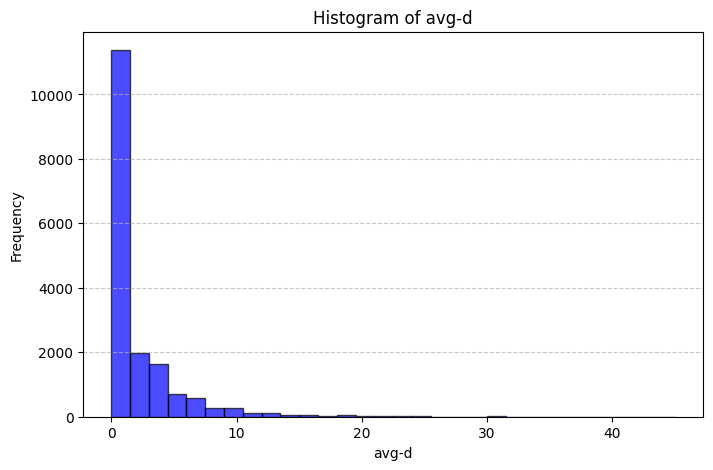

In [357]:
plothist(authstat,"avg-d")

In [358]:
len(proc_auths_all["a1_order_str"].unique())

17304

In [359]:
upd_w_lags_10[upd_w_lags_10["affs-a"]==0].head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,...,C,E,p-a,co-a,pa-a,p-c,co-c,pa-c,affs-a,affs-c


In [360]:
upd_w_lags_10[upd_w_lags_10["Author"]=="6040"] #8721

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,...,C,E,p-a,co-a,pa-a,p-c,co-c,pa-c,affs-a,affs-c
682,6040,13164,1952,1,1952,1952,1952,1951,inf,0.0,...,True,1,0.0,0.0,0.0,63.166667,4.0,13.0,{},"{cambridge massachusetts united states (city), rand corporation, massachusetts institute of tech..."
683,6040,13275,1952,1,1952,1952,1952,1951,inf,0.0,...,True,1,0.0,0.0,0.0,20.750000,18.0,5.0,{},"{institute for advanced study, princeton, new jersey, board of governors of the federal reserve ..."
684,6040,15421,1952,1,1952,1952,1952,1951,inf,0.0,...,True,1,0.0,0.0,0.0,102.333333,5.0,12.0,{},"{columbia university, conservatoire national des arts et metiers, stanford university, universit..."
685,6040,7352,1952,1,1952,1952,1952,1951,inf,0.0,...,True,1,0.0,0.0,0.0,2.500000,0.0,2.0,{},"{committee for economic development, takoma park, md. (city), american enterprise institute for ..."
686,6040,8721,1952,1,1952,1952,1952,1951,inf,0.0,...,False,2,0.0,0.0,0.0,0.000000,0.0,0.0,{},{}
687,6040,9240,1952,1,1952,1952,1952,1951,inf,0.0,...,True,1,0.0,0.0,0.0,36.000000,0.0,4.0,{},"{university of chicago, princeton university}"


In [366]:
upd_w_lags_10["avg_p"]=(upd_w_lags_10["p-a"]+upd_w_lags_10["p-c"])/2
upd_w_lags_10["abs_p"]=abs(upd_w_lags_10["p-a"]-upd_w_lags_10["p-c"])
upd_w_lags_10["c-a"]=upd_w_lags_10["co-a"]/upd_w_lags_10["pa-a"]
upd_w_lags_10["c-c"]=upd_w_lags_10["co-c"]/upd_w_lags_10["pa-c"]
upd_w_lags_10=upd_w_lags_10.fillna(0)
upd_w_lags_10["avg_c"]=(upd_w_lags_10["c-a"]+upd_w_lags_10["c-c"])/2
upd_w_lags_10["abs_c"]=abs(upd_w_lags_10["c-a"]-upd_w_lags_10["c-c"])
for i in upd_w_lags_10.index:
    if (upd_w_lags_10.loc[i,'affs-a']==0)|(upd_w_lags_10.loc[i,'affs-c']==0):
        upd_w_lags_10.loc[i,'aff_js']=0
    else:
        if (len(upd_w_lags_10.loc[i,'affs-a'])==0)|(len(upd_w_lags_10.loc[i,'affs-c'])==0):
            upd_w_lags_10.loc[i,'aff_js']=0
        else:
            upd_w_lags_10.loc[i,'aff_js']=len(upd_w_lags_10.loc[i,'affs-a'].intersection(upd_w_lags_10.loc[i,'affs-c']))/len(upd_w_lags_10.loc[i,'affs-a'].union(upd_w_lags_10.loc[i,'affs-c']))






upd_w_lags_20["avg_p"]=(upd_w_lags_20["p-a"]+upd_w_lags_20["p-c"])/2
upd_w_lags_20["abs_p"]=abs(upd_w_lags_20["p-a"]-upd_w_lags_20["p-c"])
upd_w_lags_20["c-a"]=upd_w_lags_20["co-a"]/upd_w_lags_20["pa-a"]
upd_w_lags_20["c-c"]=upd_w_lags_20["co-c"]/upd_w_lags_20["pa-c"]
upd_w_lags_20=upd_w_lags_20.fillna(0)
upd_w_lags_20["avg_c"]=(upd_w_lags_20["c-a"]+upd_w_lags_20["c-c"])/2
upd_w_lags_20["abs_c"]=abs(upd_w_lags_20["c-a"]-upd_w_lags_20["c-c"])
for i in upd_w_lags_20.index:
    if (upd_w_lags_20.loc[i,'affs-a']==0)|(upd_w_lags_20.loc[i,'affs-c']==0):
        upd_w_lags_20.loc[i,'aff_js']=0
    else:
        if (len(upd_w_lags_20.loc[i,'affs-a'])==0)|(len(upd_w_lags_20.loc[i,'affs-c'])==0):
            upd_w_lags_20.loc[i,'aff_js']=0
        else:
            upd_w_lags_20.loc[i,'aff_js']=len(upd_w_lags_20.loc[i,'affs-a'].intersection(upd_w_lags_20.loc[i,'affs-c']))/len(upd_w_lags_20.loc[i,'affs-a'].union(upd_w_lags_20.loc[i,'affs-c']))



upd_w_lags_5["avg_p"]=(upd_w_lags_5["p-a"]+upd_w_lags_5["p-c"])/2
upd_w_lags_5["abs_p"]=abs(upd_w_lags_5["p-a"]-upd_w_lags_5["p-c"])
upd_w_lags_5["c-a"]=upd_w_lags_5["co-a"]/upd_w_lags_5["pa-a"]
upd_w_lags_5["c-c"]=upd_w_lags_5["co-c"]/upd_w_lags_5["pa-c"]
upd_w_lags_5=upd_w_lags_5.fillna(0)
upd_w_lags_5["avg_c"]=(upd_w_lags_5["c-a"]+upd_w_lags_5["c-c"])/2
upd_w_lags_5["abs_c"]=abs(upd_w_lags_5["c-a"]-upd_w_lags_5["c-c"])
for i in upd_w_lags_5.index:
    if (upd_w_lags_5.loc[i,'affs-a']==0)|(upd_w_lags_5.loc[i,'affs-c']==0):
        upd_w_lags_5.loc[i,'aff_js']=0
    else:
        if (len(upd_w_lags_5.loc[i,'affs-a'])==0)|(len(upd_w_lags_5.loc[i,'affs-c'])==0):
            upd_w_lags_5.loc[i,'aff_js']=0
        else:
            upd_w_lags_5.loc[i,'aff_js']=len(upd_w_lags_5.loc[i,'affs-a'].intersection(upd_w_lags_5.loc[i,'affs-c']))/len(upd_w_lags_5.loc[i,'affs-a'].union(upd_w_lags_5.loc[i,'affs-c']))



In [367]:
upd_w_lags_10.to_pickle("flattened_co-author_10.pkl")
upd_w_lags_20.to_pickle("flattened_co-author_20.pkl")
upd_w_lags_5.to_pickle("flattened_co-author_5.pkl")


In [368]:

upd_w_lags_10.dropna().to_csv("flattened_co-author_10.csv")
upd_w_lags_20.dropna().to_csv("flattened_co-author_20.csv")
upd_w_lags_5.dropna().to_csv("flattened_co-author_5.csv")

In [369]:
upd_w_lags_10.head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,...,pa-c,affs-a,affs-c,avg_p,abs_p,c-a,c-c,avg_c,abs_c,aff_js
0,10023,15700,1950,0,1952,1952,1940,1949,inf,0.0,...,3.0,{university of liverpool},{university of chicago},10.916667,7.833333,0.000000,0.666667,0.333333,0.666667,0.00
1,10177,12194,1950,0,1956,1972,1950,1949,inf,0.0,...,0.0,"{iowa state university, university of minnesota, carnegie mellon university, university of chicago}",{university of minnesota},3.916667,7.833333,0.333333,0.000000,0.166667,0.333333,0.25
2,10333,10980,1950,0,1946,1957,1940,1949,2.0,0.5,...,16.0,"{council of economic advisors, washington dc, cornell university}",{university of chicago},61.250000,87.000000,4.500000,1.125000,2.812500,3.375000,0.00
3,10333,11857,1950,0,1946,1957,1946,1949,2.0,0.5,...,1.0,"{council of economic advisors, washington dc, cornell university}",{harvard university},9.000000,17.500000,4.500000,18.000000,11.250000,13.500000,0.00
4,10333,12583,1950,0,1946,1952,1941,1949,2.0,0.5,...,6.0,"{council of economic advisors, washington dc, cornell university}","{columbia university, national bureau of economic research - nber, new york city united states (...",17.281250,0.937500,4.500000,5.333333,4.916667,0.833333,0.00


In [370]:
upd_w_lags_10.shape

(106190, 29)

In [371]:
upd_w_lags_10[upd_w_lags_10["pa-c"]==0].head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,...,pa-c,affs-a,affs-c,avg_p,abs_p,c-a,c-c,avg_c,abs_c,aff_js
1,10177,12194,1950,0,1956,1972,1950,1949,inf,0.0,...,0.0,"{iowa state university, university of minnesota, carnegie mellon university, university of chicago}",{university of minnesota},3.916667,7.833333,0.333333,0.0,0.166667,0.333333,0.25
32,12553,14396,1950,1,1950,1950,1950,1949,inf,0.0,...,0.0,{dun and bradstreet},{dun and bradstreet},0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.00
39,1273,15278,1950,1,1950,1950,1950,1949,inf,0.0,...,0.0,{cambridge massachusetts united states (city)},{cambridge massachusetts united states (city)},0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.00
49,13861,15423,1950,1,1950,1950,1950,1949,inf,0.0,...,0.0,{northwestern university},{northwestern university},0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.00
180,5881,8596,1950,1,1950,1975,1950,1949,inf,0.0,...,0.0,"{university of washington, university of georgia}",{university of washington},5.000000,10.000000,0.000000,0.0,0.000000,0.000000,0.50


In [372]:
# upd=pd.read_pickle("upd.pkl")

In [438]:
upd_w_lags_10[["Author","Coauthor"]].drop_duplicates().shape

(18385, 2)

In [374]:
upd_w_lags_10.columns

Index(['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'p-a', 'co-a', 'pa-a',
       'p-c', 'co-c', 'pa-c', 'affs-a', 'affs-c', 'avg_p', 'abs_p', 'c-a',
       'c-c', 'avg_c', 'abs_c', 'aff_js'],
      dtype='object')

In [384]:
df_y_a=upd_w_lags_10[['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'avg_p', 'abs_p', 'avg_c', 'abs_c', 'aff_js']]
df_y_b=df_y_a.reset_index(drop=True).fillna(0).drop_duplicates(keep="first").reset_index(drop=True)
df_f=df_y_b[df_y_b["tij"]<=df_y_b["tij_1"]].reset_index(drop=True)
df_c=df_y_b[df_y_b["tij"]>df_y_b["tij_1"]].reset_index(drop=True)

In [385]:
df_y_b_5=upd_w_lags_5[['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'avg_p', 'abs_p', 'avg_c', 'abs_c', 'aff_js']].reset_index(drop=True).fillna(0).drop_duplicates(keep="first").reset_index(drop=True)
df_f_5=df_y_b_5[df_y_b_5["tij"]<=df_y_b_5["tij_1"]].reset_index(drop=True)
df_c_5=df_y_b_5[df_y_b_5["tij"]>df_y_b_5["tij_1"]].reset_index(drop=True)

In [386]:
df_y_b_20=upd_w_lags_20[['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'avg_p', 'abs_p', 'avg_c', 'abs_c', 'aff_js']].reset_index(drop=True).fillna(0).drop_duplicates(keep="first").reset_index(drop=True)
df_f_20=df_y_b_20[df_y_b_20["tij"]<=df_y_b_20["tij_1"]].reset_index(drop=True)
df_c_20=df_y_b_20[df_y_b_20["tij"]>df_y_b_20["tij_1"]].reset_index(drop=True)

In [469]:
# Select a numerical column for histogram (replace 'column_name' with actual column)
def plothist(df,column_name):
    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(df[column_name], bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {column_name}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()


def conf_stat(conf):
    tn, fp, fn, tp = conf.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(str(tn)+"true neg")
    print(str(fp)+"false pos")
    print(str(fn)+"false neg")
    print(str(tp)+"true pos")
    # Multi-class:
    precisions = np.zeros(conf.shape[0])
    recalls = np.zeros(conf.shape[0])
    
    for i in range(conf.shape[0]):
        # Calculate precision and recall for class i
        true_pos = conf[i, i]
        false_pos = sum(conf[:, i]) - true_pos
        false_neg = sum(conf[i, :]) - true_pos
        
        # Handle division by zero
        precisions[i] = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recalls[i] = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0

    # Calculate averages if needed
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)


# Function to calculate statistics for logistic regression
def get_logistic_regression_stats(model, X, feature_names=None):
    """
    Calculate p-values and significance levels for logistic regression coefficients.
    
    Parameters:
    -----------
    model : fitted sklearn.linear_model.LogisticRegression
        The fitted logistic regression model
    X : array-like
        The input features used to train the model
    feature_names : list, optional
        Names of the features (columns)
        
    Returns:
    --------
    DataFrame with coefficients, standard errors, z-values, p-values, and significance indicators
    """
    # Get coefficients and intercept
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    
    # Combine coefficients with intercept
    params = np.append(intercept, coef)
    
    # Calculate predictions and probabilities
    y_pred = model.predict(X)
    probs = model.predict_proba(X)
    
    # Design matrix with intercept
    X_design = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Calculate variance-covariance matrix
    # For logistic regression, V is a diagonal matrix of p_i * (1 - p_i)
    p = probs[:, 1]
    V = np.diagflat(p * (1 - p))
    
    # Calculate standard errors
    covb = np.linalg.inv(X_design.T @ V @ X_design)
    se = np.sqrt(np.diag(covb))
    
    # Calculate z-scores (for logistic regression, we use z instead of t)
    z_scores = params / se
    
    # Calculate p-values (two-tailed test)
    p_values = 2 * (1 - stats.norm.cdf(abs(z_scores)))

    degrees_of_freedom = X.shape[0] - X.shape[1]
    t_scores = params / se
    p_values_t = 2 * (1 - stats.t.cdf(abs(t_scores), df=degrees_of_freedom))
    
    # Create significance indicators
    significance = [''] * len(p_values)
    for i, p in enumerate(p_values):
        if p < 0.001:
            significance[i] = '***'
        elif p < 0.01:
            significance[i] = '**'
        elif p < 0.05:
            significance[i] = '*'
        elif p < 0.1:
            significance[i] = '.'

    significance_t = [''] * len(p_values_t)
    for i, p in enumerate(p_values_t):
        if p < 0.001:
            significance_t[i] = '***'
        elif p < 0.01:
            significance_t[i] = '**'
        elif p < 0.05:
            significance_t[i] = '*'
        elif p < 0.1:
            significance_t[i] = '.'
    
    # Create feature names if not provided
    if feature_names is None:
        feature_names = [f'X{i}' for i in range(X.shape[1])]
    
    # Combine results into a DataFrame
    result = pd.DataFrame({
        'Variable': ['Intercept'] + list(feature_names),
        'Coefficient': params,
        'Std. Error': se,
        'z-value': z_scores,
        'p-value': p_values,
        'Significance': significance,
        't-value':t_scores,
        'p_values_t':p_values_t,
        "Significance_t":significance_t
    })
    
    return result

from sklearn.metrics import log_loss

def calculate_pseudo_r_squared(model, X, y):
    # Make predictions (probabilities)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Calculate log-likelihood of the model
    ll_model = -log_loss(y, y_pred_proba, normalize=False)
    
    # Calculate log-likelihood of null model (intercept only)
    null_proba = np.ones(len(y)) * y.mean()
    ll_null = -log_loss(y, null_proba, normalize=False)
    
    # McFadden's R²
    r_squared_mcfadden = 1 - (ll_model / ll_null)
    
    # Cox & Snell R²
    r_squared_cox_snell = 1 - np.exp(2 * (ll_null - ll_model) / len(y))
    
    # Nagelkerke R² (adjusted Cox & Snell)
    r_squared_nagelkerke = r_squared_cox_snell / (1 - np.exp(2 * ll_null / len(y)))
    
    return {
        'McFadden': r_squared_mcfadden,
        'Cox & Snell': r_squared_cox_snell,
        'Nagelkerke': r_squared_nagelkerke
    }

In [508]:
def logi_mod(df, y, e, C=1):
    
    # Original logistic regression code
    cat_var = df[['E']]
    cat_var_2=df[['pij_t']]
    # Create and apply encoder
    encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category to avoid multicollinearity
    encoded = encoder.fit_transform(cat_var)
    
    # Create DataFrame with encoded variables
    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(['E'])
    )
    encoder_2 = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category to avoid multicollinearity

    encoded_2 = encoder_2.fit_transform(cat_var_2)
    
    # Create DataFrame with encoded variables
    encoded_df_2 = pd.DataFrame(
        encoded_2,
        columns=encoder_2.get_feature_names_out(['pij_t'])
    )
    X=df
    if e:
        # X = pd.concat([df.drop(['E'], axis=1), encoded_df, encoded_df_2], axis=1)
        con=pd.concat([encoded_df, encoded_df_2],axis=1)
    else:
        X=df.drop('E', axis=1)
        
    # Combine with other features

    # std_scaler=StandardScaler().fit(X)
    # X_std=std_scaler.transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    if e:
        X_scaled=X_scaled.drop("pij_t", axis=1)
        X_scaled=pd.concat([X_scaled, con], axis=1)

    model = LogisticRegression(fit_intercept=True, max_iter=100000, solver="newton-cg", C=C)
    model.fit(X_scaled, y)
    print(X.shape)
    
    # Calculate and display statistics
    stats_df = get_logistic_regression_stats(model, X_scaled, feature_names=X_scaled.columns)

    # Print the results
    print("\nLogistic Regression Results:")
    print(stats_df)
    
    y_pred = model.predict(X_scaled)
    print("Classification Report:")
    print(classification_report(y, y_pred, zero_division=1))
    
    print("Confusion Matrix:")
    conf=confusion_matrix(y, y_pred)
    print(conf)

    predictions = model.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    newX = pd.DataFrame({"Constant":np.ones(len(X_scaled))}).join(pd.DataFrame(X_scaled.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    print(MSE)
    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))
    print(calculate_pseudo_r_squared(model, X_scaled, y))
    
    return (classification_report(y, y_pred, zero_division=1),conf, stats_df)

def print_latex_format(mod):
    reshaped={}
    for i in range(len(mod)):
        res=mod[i][2]
        # print(res)
        # print(type(res))
        # print(res.index)
        dec=6
        just="c"
        for j in res.index:
            if res.loc[j,"Variable"] not in reshaped.keys():
                reshaped[res.loc[j,"Variable"]]="&\\makecell["+just+"]{"+str(round(res.loc[j, "Coefficient"],dec)) + str(res.loc[j, "Significance"]) +'\\\\(' +str(round(res.loc[j,'Std. Error'],dec)) +')\\\\' + str(round(res.loc[j, "p-value"],dec))+"} "
            else:
                reshaped[res.loc[j,"Variable"]]+="& \\makecell["+just+"]{"+str(round(res.loc[j, "Coefficient"],dec)) + str(res.loc[j, "Significance"]) +'\\\\(' +str(round(res.loc[j,'Std. Error'],dec)) +')\\\\' + str(round(res.loc[j, "p-value"],dec))+"}"

    for i in reshaped.keys():
        print("\makecell[l]{"+i.replace("_"," ")+"}"+reshaped[i]+"\\\\\\\\")

In [509]:
df_f.columns

Index(['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'avg_p', 'abs_p', 'avg_c',
       'abs_c', 'aff_js'],
      dtype='object')

In [510]:
mods_d=[]
E_sum=[]
for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))
    # plothist(test_df, "E")
    X=test_df[["pij_t",'log(cij)','E']].fillna(0)
    y=test_df["ytij"]
    print()
    temp_e=test_df[["Author","Coauthor","E"]].drop_duplicates()['E'].value_counts().reset_index()
    temp_e["start"]=i-10
    temp_e["end"]=i
    E_sum.append(temp_e)
    mods_d.append(logi_mod(X,y, False,1))

#########################################
1950 to 1959 inclusive
#########################################

(767, 2)

Logistic Regression Results:
    Variable  Coefficient  Std. Error   z-value       p-value Significance  \
0  Intercept    -0.474871    0.074795 -6.348948  2.167926e-10          ***   
1      pij_t     0.505930    0.479045  1.056122  2.909123e-01                
2   log(cij)    -0.590342    0.546589 -1.080047  2.801214e-01                

    t-value    p_values_t Significance_t  
0 -6.348948  3.714400e-10            ***  
1  1.056122  2.912457e-01                 
2 -1.080047  2.804618e-01                 
Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       472
           1       1.00      0.00      0.00       295

    accuracy                           0.62       767
   macro avg       0.81      0.50      0.38       767
weighted avg       0.76      0.62      0.47       767

Confusion Matrix:


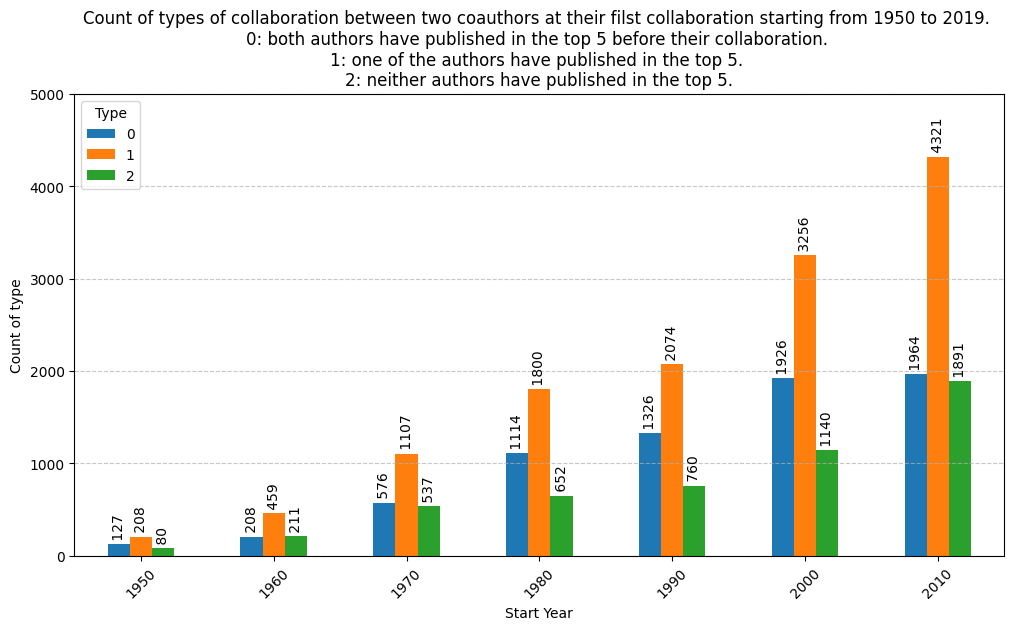

In [511]:

# Pivoting data for better visualization
df_pivot = pd.concat(E_sum).pivot(index="start", columns="E", values="count")

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot.plot(kind="bar", stacked=False, figsize=(12, 6), ax=ax)

for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 1,  # Y-coordinate (a little above the bar)
                f" {height}",  # Formatting percentage
                ha='center', va='bottom', fontsize=10, rotation=90
            )

ax.set_xlabel("Start Year")
ax.set_ylabel("Count of type")
ax.set_title("Count of types of collaboration between two coauthors at their filst collaboration starting from 1950 to 2019. \n0: both authors have published in the top 5 before their collaboration. \n1: one of the authors have published in the top 5. \n2: neither authors have published in the top 5.")
ax.set_xticklabels(df_pivot.index,rotation=45)
ax.legend(title="Type")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_ylim(0,5000)
# Show the plot
plt.show()

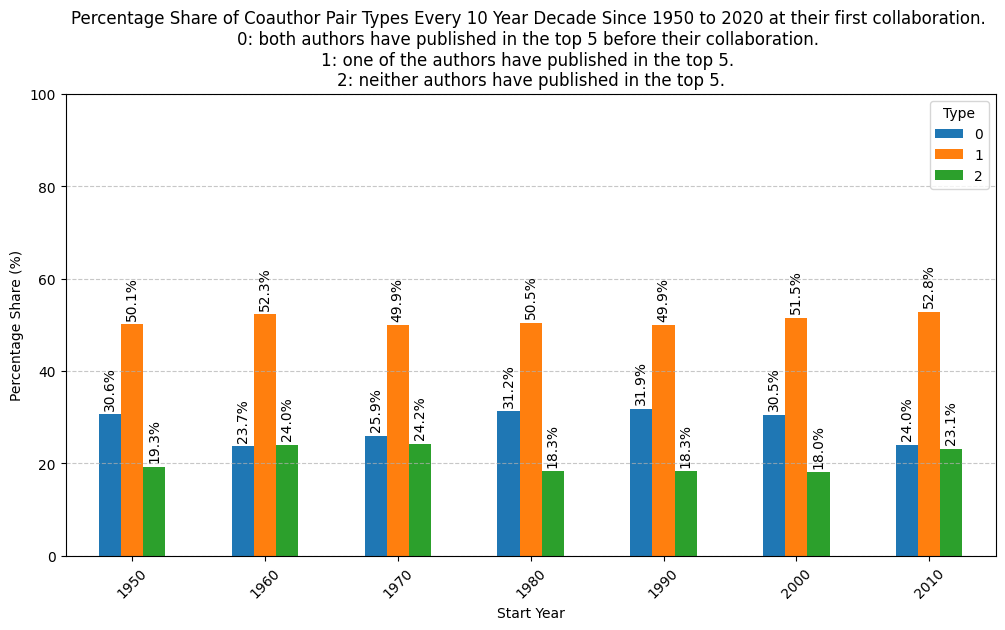

In [512]:
df_pivot_percentage = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100
# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot_percentage.plot(kind="bar", stacked=False, ax=ax)

# Adding percentage labels above the bars
for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 1,  # Y-coordinate (a little above the bar)
                f"{height:.1f}%",  # Formatting percentage
                ha='center', va='bottom', fontsize=10, rotation=90
            )

# Formatting the plot
ax.set_xlabel("Start Year")
ax.set_ylabel("Percentage Share (%)")
ax.set_title("Percentage Share of Coauthor Pair Types Every 10 Year Decade Since 1950 to 2020 at their first collaboration. \n0: both authors have published in the top 5 before their collaboration. \n1: one of the authors have published in the top 5. \n2: neither authors have published in the top 5.")
ax.set_xticklabels(df_pivot.index, rotation=45)
ax.set_ylim(0, 100)
ax.legend(title="Type")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [513]:
print_latex_format(mods_d)


\makecell[l]{Intercept}&\makecell[c]{-0.474871***\\(0.074795)\\0.0} & \makecell[c]{-0.431***\\(0.053995)\\0.0}& \makecell[c]{-0.655192***\\(0.033331)\\0.0}& \makecell[c]{-0.956667***\\(0.026402)\\0.0}& \makecell[c]{-1.038116***\\(0.02448)\\0.0}& \makecell[c]{-1.034904***\\(0.020654)\\0.0}& \makecell[c]{-0.231298***\\(0.017458)\\0.0}\\\\
\makecell[l]{pij t}&\makecell[c]{0.50593\\(0.479045)\\0.290912} & \makecell[c]{0.261651\\(0.491382)\\0.594394}& \makecell[c]{-0.070816\\(0.100209)\\0.479762}& \makecell[c]{0.138403*\\(0.062866)\\0.027697}& \makecell[c]{0.030915\\(0.050278)\\0.538635}& \makecell[c]{0.068399.\\(0.039434)\\0.08283}& \makecell[c]{0.032197\\(0.033896)\\0.342178}\\\\
\makecell[l]{log(cij)}&\makecell[c]{-0.590342\\(0.546589)\\0.280121} & \makecell[c]{-0.280827\\(0.515214)\\0.585707}& \makecell[c]{-0.045212\\(0.094097)\\0.630885}& \makecell[c]{-0.336378***\\(0.068971)\\1e-06}& \makecell[c]{-0.470314***\\(0.051048)\\0.0}& \makecell[c]{-0.607629***\\(0.040981)\\0.0}& \makecell[c]

In [514]:
df_f.columns

Index(['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'avg_p', 'abs_p', 'avg_c',
       'abs_c', 'aff_js'],
      dtype='object')

In [515]:
mods_e=[]

for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))

    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    mods_e.append(logi_mod(X,y, False, 1))

#########################################
1950 to 1959 inclusive
#########################################

(767, 7)

Logistic Regression Results:
    Variable  Coefficient  Std. Error   z-value       p-value Significance  \
0  Intercept    -0.563484    0.083945 -6.712549  1.912537e-11          ***   
1      pij_t     0.618366    0.487783  1.267708  2.049024e-01                
2   log(cij)    -0.534014    0.554187 -0.963598  3.352473e-01                
3      abs_p     0.775736    0.184249  4.210258  2.550795e-05          ***   
4      avg_p    -1.083874    0.204184 -5.308321  1.106399e-07          ***   
5      abs_c     1.422351    0.623463  2.281373  2.252636e-02            *   
6      avg_c    -1.428085    0.627815 -2.274693  2.292437e-02            *   
7     aff_js     0.546486    0.083984  6.507037  7.664780e-11          ***   

    t-value    p_values_t Significance_t  
0 -6.712549  3.741629e-11            ***  
1  1.267708  2.052907e-01                 
2 -0.963598  3.355538

In [517]:
mods_m=[]

for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_c[(df_c["tij"]<i)&(df_c["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))

    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    mods_m.append(logi_mod(X,y, False, 0.1))

#########################################
1950 to 1959 inclusive
#########################################

(1203, 7)

Logistic Regression Results:
    Variable  Coefficient  Std. Error    z-value   p-value Significance  \
0  Intercept    -4.019966    0.275522 -14.590388  0.000000          ***   
1      pij_t     0.082977    0.279139   0.297260  0.766268                
2   log(cij)     0.527573    0.316367   1.667597  0.095396            .   
3      abs_p     0.098462    0.301202   0.326897  0.743746                
4      avg_p    -0.189516    0.292341  -0.648270  0.516810                
5      abs_c    -0.406894    0.689330  -0.590274  0.555007                
6      avg_c    -0.579904    0.664740  -0.872378  0.383002                
7     aff_js     0.493902    0.150716   3.277042  0.001049           **   

     t-value  p_values_t Significance_t  
0 -14.590388    0.000000            ***  
1   0.297260    0.766320                 
2   1.667597    0.095658              .  
3   0.32

In [518]:
mods_n=[]

for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))

    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    mods_n.append(logi_mod(X,y, True, 1))

#########################################
1950 to 1959 inclusive
#########################################

(767, 8)

Logistic Regression Results:
                    Variable  Coefficient    Std. Error       z-value  \
0                  Intercept    -0.458498  2.259597e+06 -2.029116e-07   
1                   log(cij)    -0.003132  1.466130e+06 -2.135913e-09   
2                          E     1.690864  3.095701e+06  5.461976e-07   
3                      abs_p    -0.275008  1.847648e-01 -1.488425e+00   
4                      avg_p     0.527594  2.061911e-01  2.558762e+00   
5                      abs_c     0.835116  6.886859e-01  1.212622e+00   
6                      avg_c    -0.613898  6.970217e-01 -8.807449e-01   
7                     aff_js     0.453309  1.054096e-01  4.300452e+00   
8                        E_1    -0.136138  4.571657e+06 -2.977870e-08   
9                        E_2     0.633825  9.143313e+06  6.932114e-08   
10                pij_t_0.25    -0.288584  1.44311

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- pij_t
Feature names seen at fit time, yet now missing:
- E_1
- E_2
- pij_t_0.25
- pij_t_0.3333333333333333
- pij_t_0.5


In [449]:
print_latex_format(mods_e)

\makecell[l]{Intercept}&\makecell[c]{-0.563484***\\(0.083945)\\0.0} & \makecell[c]{-0.75543***\\(0.078794)\\0.0}& \makecell[c]{-0.929056***\\(0.044586)\\0.0}& \makecell[c]{-1.193856***\\(0.032718)\\0.0}& \makecell[c]{-1.311699***\\(0.030996)\\0.0}& \makecell[c]{-1.238224***\\(0.024602)\\0.0}& \makecell[c]{-0.289095***\\(0.01898)\\0.0}\\\\
\makecell[l]{pij t}&\makecell[c]{0.618366\\(0.487783)\\0.204902} & \makecell[c]{0.231614\\(0.552249)\\0.674924}& \makecell[c]{-0.261464*\\(0.112043)\\0.019616}& \makecell[c]{0.117137.\\(0.064591)\\0.06975}& \makecell[c]{0.176512***\\(0.051177)\\0.000563}& \makecell[c]{0.198137***\\(0.039453)\\1e-06}& \makecell[c]{0.261111***\\(0.034389)\\0.0}\\\\
\makecell[l]{log(cij)}&\makecell[c]{-0.534014\\(0.554187)\\0.335247} & \makecell[c]{-0.186552\\(0.581718)\\0.748444}& \makecell[c]{0.424183***\\(0.108242)\\8.9e-05}& \makecell[c]{0.049611\\(0.072117)\\0.491499}& \makecell[c]{0.100406.\\(0.055864)\\0.072287}& \makecell[c]{-0.034549\\(0.045226)\\0.44491}& \make

In [ ]:
upd_w_lags_10[["Author","Coauthor"]].drop_duplicates().shape

(18385, 2)

In [442]:
upd_w_lags_10[(upd_w_lags_10["tij_0"]==upd_w_lags_10["tij_1"])&(upd_w_lags_10["tij_2"]==upd_w_lags_10["tij_1"])][["Author","Coauthor"]].drop_duplicates().shape

(9755, 2)

In [452]:
mods_e=[]
for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f_5[(df_f_5["tij"]<i)&(df_f_5["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))

    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    mods_e.append(logi_mod(X,y, False, 1 ))

#########################################
1950 to 1959 inclusive
#########################################

(767, 7)

Logistic Regression Results:
    Variable  Coefficient  Std. Error   z-value       p-value Significance  \
0  Intercept    -0.612833    0.088027 -6.961894  3.357314e-12          ***   
1      pij_t     0.808875    0.463251  1.746082  8.079674e-02            .   
2   log(cij)    -0.674498    0.508699 -1.325927  1.848639e-01                
3      abs_p     1.041724    0.203324  5.123471  2.999624e-07          ***   
4      avg_p    -1.403936    0.231199 -6.072410  1.260050e-09          ***   
5      abs_c     1.380156    0.745480  1.851365  6.411708e-02            .   
6      avg_c    -1.409104    0.751326 -1.875489  6.072546e-02            .   
7     aff_js     0.591982    0.083186  7.116335  1.108447e-12          ***   

    t-value    p_values_t Significance_t  
0 -6.961894  7.265522e-12            ***  
1  1.746082  8.120079e-02              .  
2 -1.325927  1.852623

In [453]:
print_latex_format(mods_e)

\makecell[l]{Intercept}&\makecell[c]{-0.612833***\\(0.088027)\\0.0} & \makecell[c]{-0.635815***\\(0.070531)\\0.0}& \makecell[c]{-0.885191***\\(0.04232)\\0.0}& \makecell[c]{-1.179375***\\(0.032192)\\0.0}& \makecell[c]{-1.266905***\\(0.030028)\\0.0}& \makecell[c]{-1.193444***\\(0.023788)\\0.0}& \makecell[c]{-0.278826***\\(0.018769)\\0.0}\\\\
\makecell[l]{pij t}&\makecell[c]{0.808875.\\(0.463251)\\0.080797} & \makecell[c]{0.183459\\(0.617979)\\0.766566}& \makecell[c]{-0.223066*\\(0.106751)\\0.036654}& \makecell[c]{0.12356.\\(0.065851)\\0.060606}& \makecell[c]{0.154178**\\(0.052244)\\0.003166}& \makecell[c]{0.141386***\\(0.039978)\\0.000405}& \makecell[c]{0.212267***\\(0.034957)\\0.0}\\\\
\makecell[l]{log(cij)}&\makecell[c]{-0.674498\\(0.508699)\\0.184864} & \makecell[c]{-0.144731\\(0.652647)\\0.824501}& \makecell[c]{0.313105**\\(0.100569)\\0.00185}& \makecell[c]{-0.044206\\(0.072577)\\0.542463}& \makecell[c]{-0.142662**\\(0.054202)\\0.008487}& \makecell[c]{-0.261114***\\(0.043111)\\0.0}& 

In [ ]:
for i in range(1970,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f_20[(df_f_20["tij"]<i)&(df_f_20["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))
    print(test_df["cij_t"].unique())
    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    mods_e.append(logi_mod(X,y, False, 1 ))

#########################################
1960 to 1969 inclusive
#########################################
[0 1]

(1439, 7)

Logistic Regression Results:
    Variable  Coefficient  Std. Error   z-value       p-value Significance  \
0  Intercept    -0.763396    0.080386 -9.496674  0.000000e+00          ***   
1      pij_t     0.241372    0.540990  0.446167  6.554765e-01                
2   log(cij)    -0.197819    0.569755 -0.347199  7.284417e-01                
3      abs_p     1.463265    0.222692  6.570790  5.004908e-11          ***   
4      avg_p    -2.524037    0.280779 -8.989411  0.000000e+00          ***   
5      abs_c     0.273811    0.177277  1.544539  1.224578e-01                
6      avg_c    -0.421607    0.183271 -2.300451  2.142266e-02            *   
7     aff_js     0.643839    0.067920  9.479414  0.000000e+00          ***   

    t-value    p_values_t Significance_t  
0 -9.496674  0.000000e+00            ***  
1  0.446167  6.555439e-01                 
2 -0.347199  7

In [455]:
print_latex_format(mods_e)

\makecell[l]{Intercept}&\makecell[c]{-0.763396***\\(0.080386)\\0.0} & \makecell[c]{-0.973154***\\(0.047148)\\0.0}& \makecell[c]{-1.234341***\\(0.0342)\\0.0}& \makecell[c]{-1.33889***\\(0.031641)\\0.0}& \makecell[c]{-1.274982***\\(0.02529)\\0.0}& \makecell[c]{-0.29075***\\(0.019107)\\0.0}\\\\
\makecell[l]{pij t}&\makecell[c]{0.241372\\(0.54099)\\0.655476} & \makecell[c]{-0.359071**\\(0.119796)\\0.002723}& \makecell[c]{0.084285\\(0.063475)\\0.184228}& \makecell[c]{0.161192**\\(0.050721)\\0.001483}& \makecell[c]{0.201544***\\(0.039508)\\0.0}& \makecell[c]{0.233378***\\(0.03433)\\0.0}\\\\
\makecell[l]{log(cij)}&\makecell[c]{-0.197819\\(0.569755)\\0.728442} & \makecell[c]{0.546784***\\(0.122971)\\9e-06}& \makecell[c]{0.086051\\(0.071115)\\0.226268}& \makecell[c]{0.083978\\(0.054758)\\0.125124}& \makecell[c]{-0.035963\\(0.044383)\\0.417771}& \makecell[c]{-0.143503***\\(0.036986)\\0.000104}\\\\
\makecell[l]{abs p}&\makecell[c]{1.463265***\\(0.222692)\\0.0} & \makecell[c]{1.556855***\\(0.14439

In [ ]:
for i in range(1970,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f_20[(df_f_20["tij"]<i)&(df_f_20["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))
    print(test_df["cij_t"].unique())
    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    mods_e.append(logi_mod(X,y, False, 1 ))

In [145]:
test_df["cij_t"].unique()

array([ 0,  1,  2,  4,  3,  5,  6,  8,  9,  7, 10, 12, 14, 16, 11, 17, 15,
       13, 18, 20, 19, 37])

In [146]:
test_df[test_df["pij_t"]>0].head()

,pij_t,cij_t,ytij,tij,tij_0,tij_1,Author,Coauthor,E,avg_p,abs_p,avg_c,abs_c,log(cij)
1,0.090909,1,0,2010,2002,2017,10031,14703,0,37.833333,41.666667,0.928571,0.142857,0.000000
8,0.166667,2,0,2010,2006,2016,10121,10392,0,50.333333,27.000000,1.362500,0.475000,0.693147
9,0.125000,2,0,2010,2006,2012,10121,11069,0,20.416667,32.833333,1.800000,0.400000,0.693147
10,0.333333,1,0,2010,2007,2014,10121,16229,0,36.333333,1.000000,1.550000,0.100000,0.000000
11,0.142857,2,0,2010,2008,2014,10121,16456,0,21.416667,30.833333,1.800000,0.400000,0.693147


In [436]:
mods_e=[]
for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    print(test_df["cij_t"].unique())
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.00001))
    test_df=test_df.fillna(0)
    # test_df["pij:log(cij)"]=test_df["pij_t"]*test_df["log(cij)"]
    # test_df.loc[test_df["pij:log(cij)"]==-0,"pij:log(cij)
    # "]=0
    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c"]]
    y=test_df["ytij"]
    print()
    mods_e.append(logi_mod(X,y, False, 0.9 ))

#########################################
1950 to 1959 inclusive
#########################################
[0 1]

(767, 6)

Logistic Regression Results:
    Variable  Coefficient  Std. Error   z-value       p-value Significance  \
0  Intercept    -0.561579    0.081601 -6.881988  5.902390e-12          ***   
1      pij_t     0.621874    0.472540  1.316022  1.881666e-01                
2   log(cij)    -0.539902    0.533521 -1.011961  3.115569e-01                
3      abs_p     0.788227    0.181493  4.343011  1.405431e-05          ***   
4      avg_p    -1.238795    0.199553 -6.207837  5.371898e-10          ***   
5      abs_c     1.239883    0.587517  2.110377  3.482591e-02            *   
6      avg_c    -1.301547    0.591738 -2.199532  2.784009e-02            *   

    t-value    p_values_t Significance_t  
0 -6.881988  1.234124e-11            ***  
1  1.316022  1.885628e-01                 
2 -1.011961  3.118786e-01                 
3  4.343011  1.595736e-05            ***  
4 -6.20

In [117]:
upd_w_lags_10[(upd_w_lags_10["pij_t"]==0)&(upd_w_lags_10["cij_t"]==0)&(upd_w_lags_10["avg_p"]==0)&(upd_w_lags_10["avg_c"]==0)&(upd_w_lags_10["tij"]<=upd_w_lags_10["tij_1"])].shape
#[["shortest_path_count","pij_t","tij","tij_1"]].head()

(5733, 26)